In [27]:
# Standard Libraries
import os
import zipfile
from glob import glob
import random

# Data Manipulation Libraries
import pandas as pd

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Image Processing Libraries
import cv2

# Machine Learning Libraries
import torch
from torchvision import transforms

**Define Parameters**

In [28]:
# Paths
ZIP_PATH = '/cluster/home/bjorneme/projects/Data/chestX-ray14.zip'
EXTRACTED_PATH = '/cluster/home/bjorneme/projects/Data/chestX-ray14-extracted'

# Disease Labels
disease_labels = [
    'Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax', 'Edema',
    'Emphysema', 'Fibrosis', 'Effusion', 'Pneumonia', 'Pleural_Thickening',
    'Cardiomegaly', 'Nodule', 'Mass', 'Hernia'
]

# **Step 1: Load Data**

In [29]:
def extract_data(zip_path, extracted_path):
    """
    Extracts the ZIP file of the dataset.
    """
    os.makedirs(extracted_path, exist_ok=True)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extracted_path)

# Extract ChestX-ray14 dataset
extract_data(ZIP_PATH, EXTRACTED_PATH)

# **Step 2: Data Preprocessing**

In [30]:
def load_labels(csv_path, extracted_path):
    """
    Read labels from CSV, maps images to paths, and create binary disease labels.
    """

    # Read the CSV containing labels
    labels_df = pd.read_csv(csv_path)

    # Create binary columns for each disease label
    for disease in disease_labels:
        labels_df[disease] = labels_df['Finding Labels'].str.contains(disease).astype(int)

    # Create binary column for 'No Finding'
    labels_df['No Finding'] = labels_df['Finding Labels'].str.contains('No Finding').astype(int)

    # Map images to their full path
    labels_df['Path'] = labels_df['Image Index'].map(
        {os.path.basename(path): path for path in glob(os.path.join(extracted_path, '**', 'images', '*.png'))}
    )
    
    return labels_df

# Path to the labels CSV file
labels_csv_path = os.path.join(EXTRACTED_PATH, 'Data_Entry_2017.csv')

# Load and preprocess the labels
df = load_labels(labels_csv_path, EXTRACTED_PATH)

**Print Dataframe**

In [31]:
df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Effusion,Pneumonia,Pleural_Thickening,Cardiomegaly,Nodule,Mass,Hernia,No Finding,Path
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0,0,0,0,1,0,0,0,0,/cluster/home/bjorneme/projects/Data/chestX-ra...
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,0,0,0,0,1,0,0,0,0,/cluster/home/bjorneme/projects/Data/chestX-ra...
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0,1,0,0,1,0,0,0,0,/cluster/home/bjorneme/projects/Data/chestX-ra...
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0,0,0,0,0,0,0,0,1,/cluster/home/bjorneme/projects/Data/chestX-ra...
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0,0,0,0,0,0,0,1,0,/cluster/home/bjorneme/projects/Data/chestX-ra...


# **Step 3: Exploratory Data Analysis (EDA)**

**Number of Unique Patients**

In [32]:
unique_patients = df['Patient ID'].nunique()
print(f"Number of patients: {unique_patients}")

Number of patients: 30805


**Distribution of Disease Label**

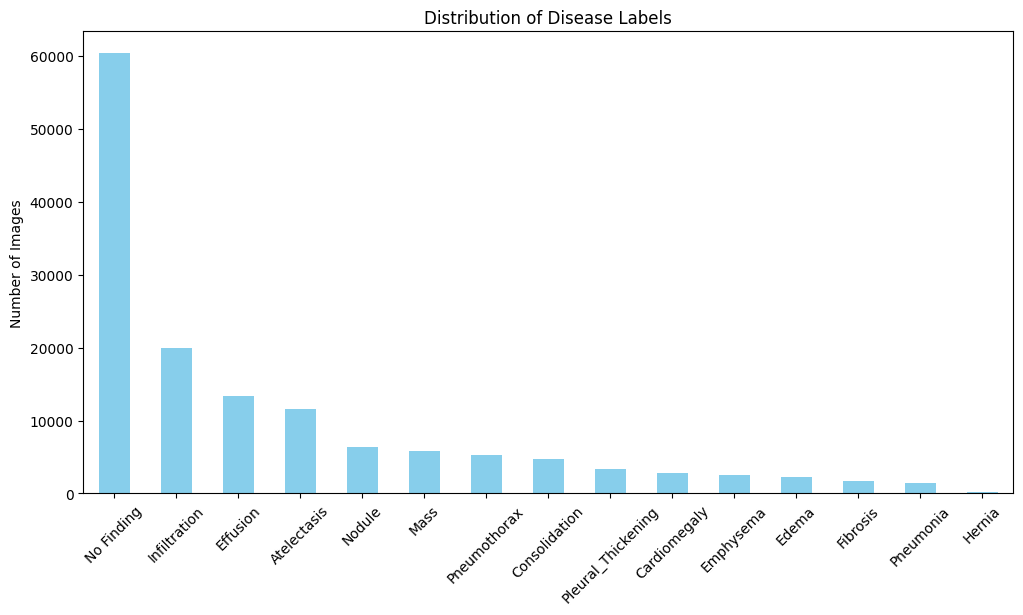

In [33]:
# Retrive labels from dataframe
labels_df = df[disease_labels + ['No Finding']]

# Count each label
counted_labels_df = labels_df.sum()

# Sort labels
counted_labels_df = counted_labels_df.sort_values(ascending=False)

# Plott counted_labels
plt.figure(figsize=(12, 6))
counted_labels_df.plot(kind='bar', color='skyblue')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.title('Distribution of Disease Labels')
plt.show()

**Distribution of Patient Age**

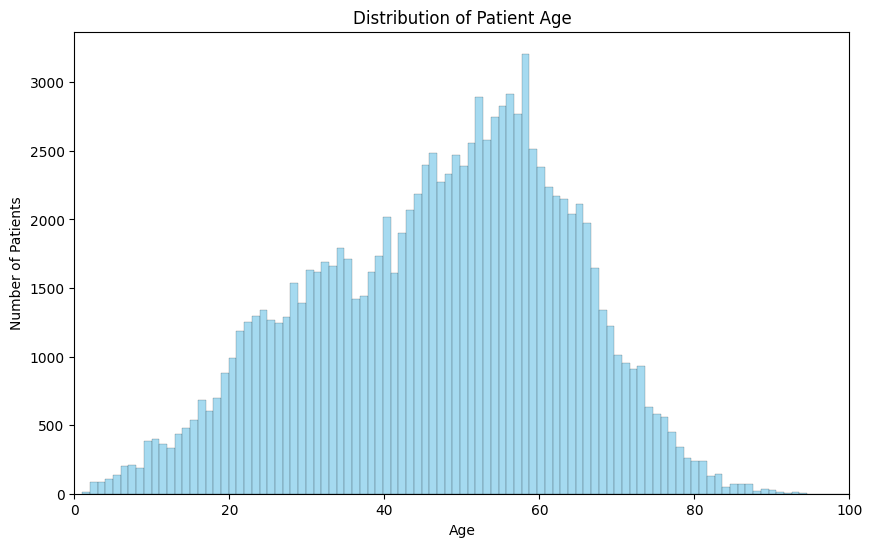

In [34]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Patient Age'], color='skyblue')
plt.title("Distribution of Patient Age")
plt.xlabel("Age")
plt.ylabel("Number of Patients")
plt.xlim(0, 100)
plt.show()

**Distribution of Patient Gender**

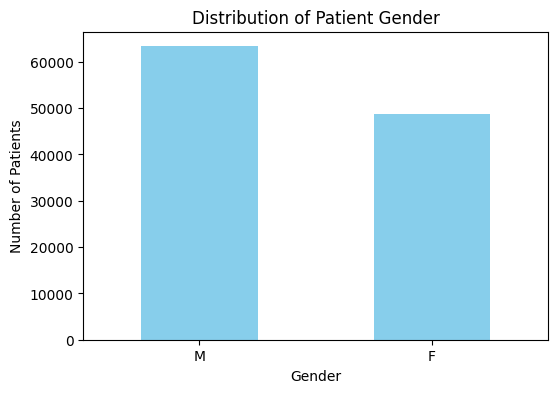

In [35]:
# Count number of each gender
gender_df = df['Patient Gender'].value_counts()

# Plot distribution of gender
plt.figure(figsize=(6, 4))
gender_df.plot(kind='bar', color='skyblue')
plt.title("Distribution of Patient Gender")
plt.xlabel("Gender")
plt.xticks(rotation=0)
plt.ylabel("Number of Patients")
plt.show()

**Distribution of Patient View Position**

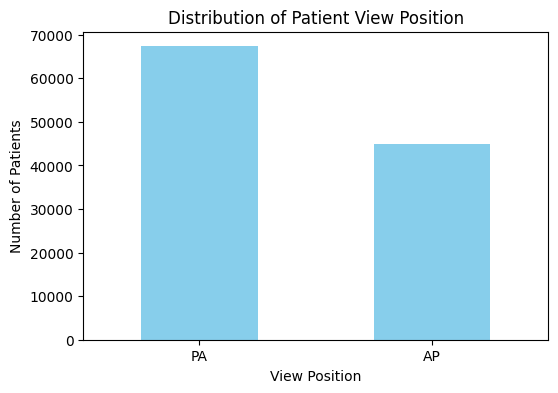

In [36]:
# Count number of each view position
view_position_df = df['View Position'].value_counts()

# Plot distribution of view positions
plt.figure(figsize=(6, 4))
view_position_df.plot(kind='bar', color='skyblue')
plt.title("Distribution of Patient View Position")
plt.xlabel("View Position")
plt.xticks(rotation=0)
plt.ylabel("Number of Patients")
plt.show()


**Diseases per Image Distribution**

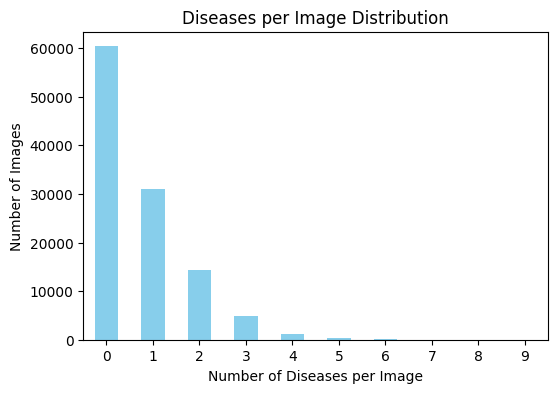

In [37]:
# Count number of diseases per image
df['Number of Diseases'] = df[disease_labels].sum(axis=1)

# Count occurrences of each number of diseases
disease_count_distribution = df['Number of Diseases'].value_counts()

# Sort in descending order by index
disease_count_distribution = df['Number of Diseases'].value_counts().sort_index()

# Plot the distribution
plt.figure(figsize=(6, 4))
disease_count_distribution.plot(kind='bar', color='skyblue')
plt.title("Diseases per Image Distribution")
plt.xlabel("Number of Diseases per Image")
plt.ylabel("Number of Images")
plt.xticks(rotation=0)
plt.show()

**Distribution of Co-occurrence of Labels**

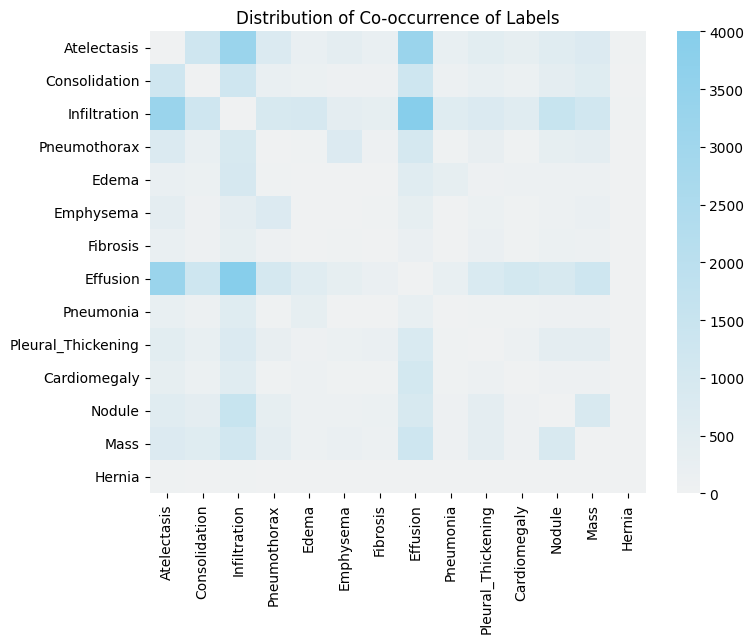

In [38]:
# Calculate co-occurrence
co_occurrence_df = df[disease_labels].T.dot(df[disease_labels])

# Remove the diagonal
for disease in disease_labels:
    co_occurrence_df.loc[disease, disease] = 0

# Create a skyblue colormap
custom_cmap = sns.light_palette("skyblue", as_cmap=True)

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(co_occurrence_df, cmap=custom_cmap)
plt.title("Distribution of Co-occurrence of Labels")
plt.show()

**Plot Samples for Dataset to Verify Image Quality**

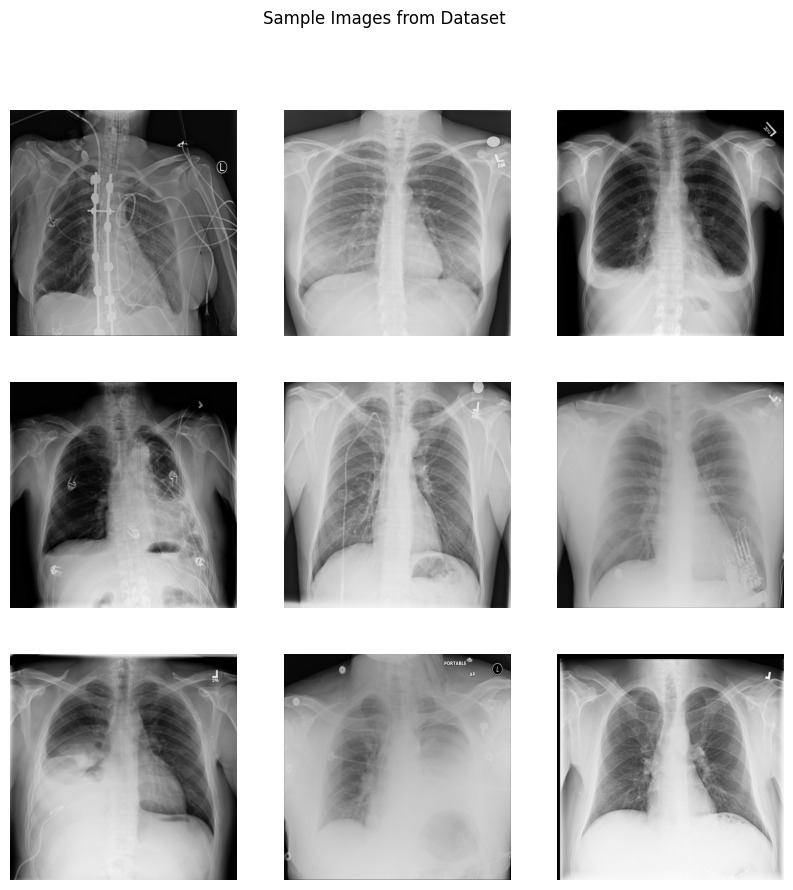

In [39]:
# Randomly select 9 images
sample_images = random.sample(list(df['Path']), 9)

# Plot the samples
plt.figure(figsize=(10, 10))
for i, img_path in enumerate(sample_images):
    img = cv2.imread(img_path)
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.suptitle("Sample Images from Dataset")
plt.show()